In [1]:
import os
import pickle
import time
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError
from utils.preprocess import *

In [2]:
print(tf.__version__)

# we need to set up gpus for tensorflow-gpu and cudnn
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)

tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Download, read in, preprocess data

In [4]:
model_prefix = ''
days = 7
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=False)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=False)
    labeled_data.to_csv()

Reading csv


In [5]:
# read in data, extract data and labels
labeled_data = preprocess(labeled_data)
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

One of the first things we need to take care of is the precipitation column. There are some extremely high values throughout the dataset that we need to drop.

In [6]:
precip_cols = [col for col in regions.columns if 'precip' in col and 'exposed' not in col]
regions_precip = regions.loc[:, precip_cols]
regions_precip

,,precip_0,precip_1,precip_2,precip_3,precip_4,precip_5
region,date,,,,,,
3031,2017-11-22,25.7,0.0,0.6,0.2,22.7,23.9
3034,2017-11-22,47.0,3.0,0.0,0.3,24.8,29.9
3031,2017-11-23,55.4,25.7,0.0,0.6,0.2,22.7
3034,2017-11-23,53.1,47.0,3.0,0.0,0.3,24.8
3007,2017-11-29,9.3,14.4,5.7,0.3,0.0,2.9
...,...,...,...,...,...,...,...
3031,2021-01-12,0.0,5.0,10.0,15.0,0.0,0.0
3032,2021-01-12,0.0,0.0,3.0,2.0,0.0,0.0
3034,2021-01-12,0.0,4.0,12.0,10.0,0.0,0.0


There is a set of anomalously high precipitation values in this dataset that we need to be mindful of.

In [7]:
precip_outliers = np.where(regions_precip > 100)[0]
regions_precip.iloc[precip_outliers].head(25)

,,precip_0,precip_1,precip_2,precip_3,precip_4,precip_5
region,date,,,,,,
3006,2020-04-30,6280.500,0.0,0.1,0.3,0.900,1.7
3007,2020-04-30,6280.500,0.0,0.0,0.2,1.300,1.5
3009,2020-04-30,6280.900,0.0,0.0,0.3,1.200,1.6
3010,2020-04-30,6280.500,0.0,0.0,0.2,1.100,2.2
3011,2020-04-30,6280.500,0.0,0.0,0.0,0.700,1.0
3012,2020-04-30,6280.500,0.0,0.0,0.0,0.300,0.7
3013,2020-04-30,6280.858,0.0,0.0,0.1,0.600,1.1
3014,2020-04-30,6280.500,0.0,0.0,0.0,0.200,0.1
3015,2020-04-30,6280.500,0.0,0.0,0.0,0.700,1.1


In [8]:
drop_idx = regions.index[precip_outliers]
regions = regions.drop(drop_idx)
regions

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,regobs_snowprofile_t_min_4_4,regobs_snowprofile_t_min_4_5,regobs_snowprofile_t_min_4_6,regobs_snowprofile_t_min_4_7,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7
region,date,,,,,,,,,,,,,,,,,,,,,
3031,2017-11-22,35.75,0.60,1.3,0.4,27.6,29.2,25.7,0.0,0.6,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2017-11-22,56.40,4.90,0.0,0.3,28.8,36.0,47.0,3.0,0.0,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3031,2017-11-23,79.70,35.75,0.6,1.3,0.4,27.6,55.4,25.7,0.0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2017-11-23,65.90,56.40,4.9,0.0,0.3,28.8,53.1,47.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,2017-11-29,9.70,16.90,7.2,0.7,0.0,3.4,9.3,14.4,5.7,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.00,10.00,15.0,20.0,2.0,0.0,0.0,5.0,10.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3032,2021-01-12,0.00,2.00,6.0,5.0,0.0,0.0,0.0,0.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2021-01-12,2.00,8.00,20.0,20.0,0.0,0.0,0.0,4.0,12.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
regions.loc[:, precip_cols].max()

precip_0    95.6
precip_1    95.6
precip_2    95.6
precip_3    95.6
precip_4    95.6
precip_5    95.6
dtype: float64

These seem like more reasonable values. We need to do the same thing for the labels, though.

In [10]:
labels = labels.drop(drop_idx)

In [11]:
print('Shape of input data:  {}'.format(regions.shape))
print('Shape of labels    :  {}'.format(labels.shape))

Shape of input data:  (12970, 5238)
Shape of labels    :  (12970, 69)


In [12]:
# encode cause and aspect columns in labels
labels = encode_causes(labels)
labels = encode_aspects(labels)

In a previous Notebook analysis on the importance of different features, we say that different meteorological variables from RegObs are often more important than other fields included in the data. And what's more, combining variables to create custom features is even *more* important. We can create those features again below.

**Why do we want to do feed in weather data to a neural network when other data is available?** This is a good question. Generally, we cannot send people everywhere to inspect avalanche conditions. That means that there are many places where the *only* data that we have available comes in the form of weather forecasts and observations. Thus, it is important to see if a model can predict danger level or the first avalanche problem given only weather data.

In [13]:
def wind_speed_max(df, col_list):
    """
    Create wind_speed_max_# columns from wind_speed_# and wind_change_speed_#
    input columns. This will drop the wind_speed_# and wind_change_speed_# columns.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for the wind_speed_# and wind_change_speed_# features
    
    Returns:
        df(DataFrame): same input data frame with new wind_speed_max_# columns
    """
    # so there is a wind_speed and wind_change_speed column for each day
    # that means that there are len(col_list) / 2 unique days
    for day in range(int(len(col_list) / 2)):
        speed_col = 'wind_speed_' + str(day)
        change_col = 'wind_change_speed_' + str(day)
        max_col = 'wind_speed_max_' +str(day)
        
        # take the max over rows
        df[max_col] = df.loc[:, [speed_col, change_col]].max(axis=1)
        
    # drop unwanted wind columns
    #df.drop(col_list, axis=1, inplace=True)
    return df

In [14]:
def sum_over_features(df, col_list, new_name, drop=False):
    """
    Create column for maximum wind speed over the past 72 hours.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for a set of features; this could be wind, precip, etc.
        new_name(str): what you want the new column name to be
        drop(bool): whether to drop the columns in col_list before returning df
        
    NOTE: You need to make sure you pass in intelligible columns. For instance, it may not make sense to
          sum over certain columns. Additionally, all of the input columns should follow the same
          naming convection, i.e., `precip_0`, `precip_`, `precip_3`
    
    Returns:
        df(DataFrame): same input dataframe with summed column, after dropping input columns
    """
    # sum over rows, or each day
    df[new_name] = df.loc[:, col_list].sum(axis=1)
    
    # drop unwanted columns
    if drop == True:
        df.drop(col_list, axis=1, inplace=True)
    
    return df

In [15]:
def take_max(df, col_list, new_name, drop=False):
    """
    Create a column for the max value given over the past 3 days (72 hours).
    This will drop the input columns in col_list if drop is set to True.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for creating the max value
        new_name(str): what you want the new column name to be
        drop(bool): whether to drop the columns in col_list before returning df
    
    Returns:
        df(DataFrame): same input data frame with new max value column
    """
    # take the max over rows
    df[new_name] = df.loc[:, col_list].max(axis=1)
    
    # drop unwanted columns
    if drop == True:
        df.drop(col_list, axis=1, inplace=True)
    
    return df

In [16]:
# drop wind speed columns
wind_dir_cols = [col for col in regions.columns if 'wind_dir' in col]
#regions.drop(wind_dir_cols, axis=1, inplace=True)

# create 72 hour sum or max of wind speed, precip, and max temp
wind_speed_cols = [col for col in regions.columns if 'wind' in col and 'speed' in col]
regions = wind_speed_max(regions, wind_speed_cols)
to_sum = ['wind_speed_max_0', 'wind_speed_max_1', 'wind_speed_max_2']
regions = sum_over_features(regions, to_sum, 'wind_speed_72hr')

to_sum = ['precip_0', 'precip_1', 'precip_2']
regions = sum_over_features(regions, to_sum, 'precip_72hr')

to_sum = ['temp_max_0', 'temp_max_1', 'temp_max_2']
regions = take_max(regions, to_sum, 'temp_max_72hr')

In [17]:
dont_include_list = ['acc', 'dir', 'fl_start', 'regobs', 'start']
all_wx_cols = [col for col in regions.columns]

for drop_col in dont_include_list:
    all_wx_cols = [col for col in all_wx_cols if drop_col not in col]

#all_wx_cols

In [18]:
train = regions.loc[:, all_wx_cols]
train

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,temp_freeze_lev_5,wind_speed_max_0,wind_speed_max_1,wind_speed_max_2,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,,,,,,,,,,,,,,,,,,,
3031,2017-11-22,35.75,0.60,1.3,0.4,27.6,29.2,25.7,0.0,0.6,0.2,...,769.990,18.5,5.5,0.0,5.5,0.0,0.0,24.0,26.3,-3.5
3034,2017-11-22,56.40,4.90,0.0,0.3,28.8,36.0,47.0,3.0,0.0,0.3,...,1138.400,18.5,9.0,5.5,9.0,0.0,0.0,33.0,50.0,-2.0
3031,2017-11-23,79.70,35.75,0.6,1.3,0.4,27.6,55.4,25.7,0.0,0.6,...,731.790,15.5,18.5,5.5,0.0,5.5,0.0,39.5,81.1,3.0
3034,2017-11-23,65.90,56.40,4.9,0.0,0.3,28.8,53.1,47.0,3.0,0.0,...,1128.605,18.5,18.5,9.0,5.5,9.0,0.0,46.0,103.1,3.0
3007,2017-11-29,9.70,16.90,7.2,0.7,0.0,3.4,9.3,14.4,5.7,0.3,...,44.970,12.0,12.0,5.5,12.0,12.0,23.0,29.5,29.4,-4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.00,10.00,15.0,20.0,2.0,0.0,0.0,5.0,10.0,15.0,...,0.000,9.0,5.5,5.5,15.5,0.0,0.0,20.0,15.0,-5.0
3032,2021-01-12,0.00,2.00,6.0,5.0,0.0,0.0,0.0,0.0,3.0,2.0,...,0.000,12.0,5.5,9.0,12.0,0.0,0.0,26.5,3.0,-9.0
3034,2021-01-12,2.00,8.00,20.0,20.0,0.0,0.0,0.0,4.0,12.0,10.0,...,0.000,9.0,5.5,9.0,12.0,5.5,5.5,23.5,16.0,-7.0


In [19]:
# to_include = [col for col in regions.columns if '72hr' in col]
# train = regions.loc[:, to_include]
# train

In [20]:
def scale_input_data(X):
    """
    Scale input features from [-1, 1] so that it is easier to
    train a neural network.
    """
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(X)
    return scaled

In [21]:
scaled_X = scale_input_data(train.values)
train = pd.DataFrame(scaled_X, columns=train.columns, index=train.index)
train

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,temp_freeze_lev_5,wind_speed_max_0,wind_speed_max_1,wind_speed_max_2,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,,,,,,,,,,,,,,,,,,,
3031,2017-11-22,0.300168,0.005038,0.010915,0.003359,0.231738,0.245172,0.268828,0.000000,0.006276,0.002092,...,0.307996,0.616667,0.183333,0.000000,0.183333,0.000000,0.000000,0.289157,0.172140,0.471109
3034,2017-11-22,0.473552,0.041142,0.000000,0.002519,0.241814,0.302267,0.491632,0.031381,0.000000,0.003138,...,0.455360,0.616667,0.300000,0.183333,0.300000,0.000000,0.000000,0.397590,0.327262,0.504165
3031,2017-11-23,0.669186,0.300168,0.005038,0.010915,0.003359,0.231738,0.579498,0.268828,0.000000,0.006276,...,0.292716,0.516667,0.616667,0.183333,0.000000,0.183333,0.000000,0.475904,0.530818,0.614351
3034,2017-11-23,0.553317,0.473552,0.041142,0.000000,0.002519,0.241814,0.555439,0.491632,0.031381,0.000000,...,0.451442,0.616667,0.616667,0.300000,0.183333,0.300000,0.000000,0.554217,0.674813,0.614351
3007,2017-11-29,0.081444,0.141898,0.060453,0.005877,0.000000,0.028547,0.097280,0.150628,0.059623,0.003138,...,0.017988,0.400000,0.400000,0.183333,0.400000,0.400000,0.766667,0.355422,0.192430,0.457887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.000000,0.083963,0.125945,0.167926,0.016793,0.000000,0.000000,0.052301,0.104603,0.156904,...,0.000000,0.300000,0.183333,0.183333,0.516667,0.000000,0.000000,0.240964,0.098178,0.438054
3032,2021-01-12,0.000000,0.016793,0.050378,0.041982,0.000000,0.000000,0.000000,0.000000,0.031381,0.020921,...,0.000000,0.400000,0.183333,0.300000,0.400000,0.000000,0.000000,0.319277,0.019636,0.349905
3034,2021-01-12,0.016793,0.067170,0.167926,0.167926,0.000000,0.000000,0.000000,0.041841,0.125523,0.104603,...,0.000000,0.300000,0.183333,0.300000,0.400000,0.183333,0.183333,0.283133,0.104724,0.393979


In [22]:
print(np.any(np.isnan(train)))

False


In [23]:
# could use CLASS_danger_level or CLASS_problem_1
train_labels = labels.loc[:, ['CLASS_danger_level']]
train_labels

,,CLASS_danger_level
region,date,
3031,2017-11-22,4
3034,2017-11-22,4
3031,2017-11-23,4
3034,2017-11-23,4
3007,2017-11-29,3
...,...,...
3031,2021-01-12,3
3032,2021-01-12,3
3034,2021-01-12,3


In [24]:
train['danger_level'] = train_labels
train

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,wind_speed_max_0,wind_speed_max_1,wind_speed_max_2,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_72hr,precip_72hr,temp_max_72hr,danger_level
region,date,,,,,,,,,,,,,,,,,,,,,
3031,2017-11-22,0.300168,0.005038,0.010915,0.003359,0.231738,0.245172,0.268828,0.000000,0.006276,0.002092,...,0.616667,0.183333,0.000000,0.183333,0.000000,0.000000,0.289157,0.172140,0.471109,4
3034,2017-11-22,0.473552,0.041142,0.000000,0.002519,0.241814,0.302267,0.491632,0.031381,0.000000,0.003138,...,0.616667,0.300000,0.183333,0.300000,0.000000,0.000000,0.397590,0.327262,0.504165,4
3031,2017-11-23,0.669186,0.300168,0.005038,0.010915,0.003359,0.231738,0.579498,0.268828,0.000000,0.006276,...,0.516667,0.616667,0.183333,0.000000,0.183333,0.000000,0.475904,0.530818,0.614351,4
3034,2017-11-23,0.553317,0.473552,0.041142,0.000000,0.002519,0.241814,0.555439,0.491632,0.031381,0.000000,...,0.616667,0.616667,0.300000,0.183333,0.300000,0.000000,0.554217,0.674813,0.614351,4
3007,2017-11-29,0.081444,0.141898,0.060453,0.005877,0.000000,0.028547,0.097280,0.150628,0.059623,0.003138,...,0.400000,0.400000,0.183333,0.400000,0.400000,0.766667,0.355422,0.192430,0.457887,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.000000,0.083963,0.125945,0.167926,0.016793,0.000000,0.000000,0.052301,0.104603,0.156904,...,0.300000,0.183333,0.183333,0.516667,0.000000,0.000000,0.240964,0.098178,0.438054,3
3032,2021-01-12,0.000000,0.016793,0.050378,0.041982,0.000000,0.000000,0.000000,0.000000,0.031381,0.020921,...,0.400000,0.183333,0.300000,0.400000,0.000000,0.000000,0.319277,0.019636,0.349905,3
3034,2021-01-12,0.016793,0.067170,0.167926,0.167926,0.000000,0.000000,0.000000,0.041841,0.125523,0.104603,...,0.300000,0.183333,0.300000,0.400000,0.183333,0.183333,0.283133,0.104724,0.393979,3


In [25]:
np.unique(train_labels)

array([1, 2, 3, 4])

In [26]:
class_occurrences = (train_labels.value_counts() / len(train_labels) * 100).sort_index()
round(class_occurrences, 2)

CLASS_danger_level
1                     19.06
2                     52.10
3                     26.66
4                      2.18
dtype: float64

So we see that there is a heavy imbalance in the class weights that we are trying to predict. This is not ideal for our case, because more than anything we need to reliably be able to predict danger levels 3 and 4. Scikit-learn makes this easy to do for imbalanced classification tasks.

In [27]:
flat_values = [value[0] for value in train_labels.values]
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(flat_values),
                                            flat_values)

print(weights)

[ 1.31169094  0.47987272  0.93768074 11.45759717]


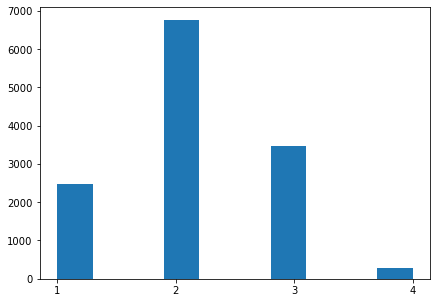

In [28]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(sorted([str(value) for value in flat_values]), align='mid', )#rwidth=0.85)
plt.show()

In [29]:
class_weights = {
    0: 2.5,
    1: 1,
    2: 2,
    3: 10
}

# Split data

In [30]:
train_idx = [3007, 3012, 3010, 3009, 3013, 3017, 3014, 3032, 
             3027, 3029, 3022, 3031, 3023, 3037, 3024, 3028]
val_idx =   [3011, 3016, 3035]
test_idx =  [3006, 3015, 3034]

X_train = [train.loc[idx].values for idx in train_idx]
y_train = [train_labels.loc[idx].values for idx in train_idx]

X_val = [train.loc[idx].values for idx in val_idx]
y_val = [train_labels.loc[idx].values for idx in val_idx]

X_test = [train.loc[idx].values for idx in test_idx]
y_test = [train_labels.loc[idx].values for idx in test_idx]

In [31]:
print(len(train_idx), len(X_train), len(y_train))
print(len(val_idx), len(X_val), len(y_val))
print(len(test_idx), len(X_test), len(y_test))

16 16 16
3 3 3
3 3 3


In [32]:
print(np.any(np.isnan(np.concatenate(X_train))))
print(np.any(np.isnan(np.concatenate(y_train))))
print(np.any(np.isnan(np.concatenate(X_val))))
print(np.any(np.isnan(np.concatenate(y_val))))

False
False
False
False


In [33]:
def pad_sequence(arr, length):
    """
    This method will pad a m x n array so that m is perfectly
    divisible by length. That is, m % length == 0.
    
    Arguments:
        arr(array): m x n array where there are n input features of length m
        length(int): what we want the length of of arr to be divisible by
        
    Returns:
        padded(array): new padded array
    """
    n_features = arr.shape[1]
    remainder = arr.shape[0] % length
    if remainder == 0: # then nothing to pad
        return arr
    
    pad_length = length - remainder
    to_add = np.zeros((pad_length, n_features))
    padded = np.concatenate([arr, to_add])
    #padded = np.concatenate([to_add, arr])
    
    return padded

In [34]:
sequence_length = 14 # this is an arbitrary choice, a hyperparameter
X_train_pad = [pad_sequence(arr, sequence_length) for arr in X_train]
y_train_pad = [pad_sequence(arr, sequence_length) for arr in y_train]

X_val_pad = [pad_sequence(arr, sequence_length) for arr in X_val]
y_val_pad = [pad_sequence(arr, sequence_length) for arr in y_val]

X_test_pad = [pad_sequence(arr, sequence_length) for arr in X_test]
y_test_pad = [pad_sequence(arr, sequence_length) for arr in y_test]

In [35]:
for (arr, label) in zip(X_train_pad, y_train_pad):
    print(arr.shape, label.shape)

(602, 58) (602, 1)
(602, 58) (602, 1)
(602, 58) (602, 1)
(602, 58) (602, 1)
(602, 58) (602, 1)
(602, 58) (602, 1)
(602, 58) (602, 1)
(602, 58) (602, 1)
(602, 58) (602, 1)
(602, 58) (602, 1)
(602, 58) (602, 1)
(602, 58) (602, 1)
(602, 58) (602, 1)
(350, 58) (350, 1)
(602, 58) (602, 1)
(602, 58) (602, 1)


### Creating a windowed dataset
- https://curiousily.com/posts/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python/
- https://stackoverflow.com/questions/45435049/lstm-understand-timesteps-samples-and-features-and-especially-the-use-in-resha
- https://stackoverflow.com/questions/48491737/understanding-keras-lstms-role-of-batch-size-and-statefulness

Instead of jumping by `sequence_length` below, we need to shift by a certain amount every time. So use days 1-7 to predict day 8, days 2-8 to predict day 9, etc.

Then the labels should start by predicting day 8, 9, etc.

In [36]:
# reshape data into (samples, timesteps, features)
X_concat_train = np.concatenate(X_train)
y_concat_train = np.concatenate(y_train)

X_concat_val = np.concatenate(X_val)
y_concat_val = np.concatenate(y_val)

print(X_concat_train.shape)
print(y_concat_train.shape)

print(X_concat_val.shape)
print(y_concat_val.shape)

(9242, 58)
(9242, 1)
(1780, 58)
(1780, 1)


In [37]:
def batch_data(x, y, length):
    """
    Batch the neural network data, creating a shifting window of data at each time step.
    """    
    #create empty lists to append to
    X, Y = [], []
    
    #iterate over dataset, looking at moving window of 1 timestep
    #need to length to prevent out of bounds errors
    for i in range(0, len(x)-length):
        x_batch = x[i:length+i]
        y_batch = y[length+i]
        
        #append batches to lists
        X.append(x_batch)
        Y.append(y_batch)
    
    #convert lists to numpy arrays before turning into torch tensors
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    print(X.shape, Y.shape)
    return X, Y

In [38]:
batchX_train, batchY_train = batch_data(X_concat_train, y_concat_train, sequence_length)
batchX_val, batchY_val = batch_data(X_concat_val, y_concat_val, sequence_length)

(9228, 14, 58) (9228, 1)
(1766, 14, 58) (1766, 1)


In [39]:
print(np.any(np.isnan(batchX_train)))
print(np.any(np.isnan(batchY_train)))
print(np.any(np.isnan(batchX_val)))
print(np.any(np.isnan(batchY_val)))

False
False
False
False


# Training a neural network

## DNN
We can define our neural network below. This is a multiclass classification problem, meaning that we need as many output units in the last layer as there are unique labels in our training set. It also means that we should use a softmax activation in the last layer and some form of categorical crossentropy as the loss function.

In [40]:
def create_dnn(X, n_input, dropout, n_output, add_reg=False):
    """
    Create a DNN with or without regularization. Note: X should have
    shape (samples, timesteps, features)
    """
    timesteps = X.shape[1]
    features = X.shape[2]
    
    # design network
    dnn = tf.keras.models.Sequential()
    if(add_reg == True):
        reg = tf.keras.regularizers.l2(l=0.0001)
        dnn.add(Dense(n_input, activation='elu', kernel_regularizer=reg, input_shape=(timesteps, features)))
        dnn.add(Dropout(dropout))
        dnn.add(Dense(n_input, activation='elu', kernel_regularizer=reg))
        
    else:
        dnn.add(Dense(n_input, activation='elu', input_shape=(timesteps, features)))
        dnn.add(Dropout(dropout))
        dnn.add(Dense(n_input, activation='elu'))
    
    dnn.add(Dropout(dropout))
    dnn.add(tf.keras.layers.Flatten())
    dnn.add(Dense(n_output, activation='softmax'))
    
    return dnn

In [41]:
def train(model, X, y, X_val, y_val, loss, opt, batch, e, w):
    """
    Train a neural network with passed in hyperparameters.
    """
    # compile and fit model
    model.compile(loss=loss, 
                  optimizer=opt, 
                  metrics=['sparse_categorical_accuracy'])

    history = model.fit(X, y, validation_data=(X_val, y_val),
                        batch_size=batch, epochs=e, verbose=1, 
                        shuffle=False, class_weight=w)
    
    return history

In [42]:
def plot_history(history):
    """
    Plot the loss function vs epochs and metric vs epochs after
    training a neural network.
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # plot loss over time
    ax[0].plot(history.history['loss'], label='train')
    ax[0].plot(history.history['val_loss'], label='val')
    
    # plot metric over time
    ax[1].plot(history.history['sparse_categorical_accuracy'], label='train')
    ax[1].plot(history.history['val_sparse_categorical_accuracy'], label='val')
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    
    ax[0].legend()
    ax[1].legend()
    plt.show()

In [43]:
# network params
input_neurons = 100
output_neurons = len(np.unique(y_concat_train))
drop = 0.3

# training params
num_epochs = 200
alpha = 1e-3
batch_size = 32
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=alpha)

In [44]:
window_dnn = create_dnn(batchX_train, input_neurons, drop, output_neurons)

window_dnn_history = train(window_dnn, batchX_train, batchY_train-1, 
                           batchX_val, batchY_val-1, criterion, optimizer, 
                           batch_size, num_epochs, class_weights)

Epoch 1/200
289/289 [==============================] - 1s 2ms/step - loss: 1.8094 - sparse_categorical_accuracy: 0.5415 - val_loss: 1.1809 - val_sparse_categorical_accuracy: 0.3941
Epoch 2/200
289/289 [==============================] - 0s 2ms/step - loss: 1.4608 - sparse_categorical_accuracy: 0.6622 - val_loss: 1.1665 - val_sparse_categorical_accuracy: 0.4162
Epoch 3/200
289/289 [==============================] - 0s 2ms/step - loss: 1.3982 - sparse_categorical_accuracy: 0.6798 - val_loss: 1.1153 - val_sparse_categorical_accuracy: 0.4592
Epoch 4/200
289/289 [==============================] - 0s 2ms/step - loss: 1.3579 - sparse_categorical_accuracy: 0.6958 - val_loss: 1.1668 - val_sparse_categorical_accuracy: 0.4224
Epoch 5/200
289/289 [==============================] - 0s 2ms/step - loss: 1.3462 - sparse_categorical_accuracy: 0.6992 - val_loss: 1.1496 - val_sparse_categorical_accuracy: 0.4275
Epoch 6/200
289/289 [==============================] - 1s 2ms/step - loss: 1.3361 - sparse_cate

289/289 [==============================] - 0s 2ms/step - loss: 1.2003 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.8280 - val_sparse_categorical_accuracy: 0.6382
Epoch 47/200
289/289 [==============================] - 0s 2ms/step - loss: 1.2128 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.7710 - val_sparse_categorical_accuracy: 0.6767
Epoch 48/200
289/289 [==============================] - 0s 2ms/step - loss: 1.2043 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.8116 - val_sparse_categorical_accuracy: 0.6523
Epoch 49/200
289/289 [==============================] - 0s 2ms/step - loss: 1.2136 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.8105 - val_sparse_categorical_accuracy: 0.6546
Epoch 50/200
289/289 [==============================] - 0s 2ms/step - loss: 1.1982 - sparse_categorical_accuracy: 0.7243 - val_loss: 0.7872 - val_sparse_categorical_accuracy: 0.6761
Epoch 51/200
289/289 [==============================] - 0s 2ms/step - loss: 1.1995 - sparse_categorical

289/289 [==============================] - 0s 2ms/step - loss: 1.1544 - sparse_categorical_accuracy: 0.7248 - val_loss: 0.8007 - val_sparse_categorical_accuracy: 0.6659
Epoch 92/200
289/289 [==============================] - 0s 2ms/step - loss: 1.1615 - sparse_categorical_accuracy: 0.7191 - val_loss: 0.8019 - val_sparse_categorical_accuracy: 0.6591
Epoch 93/200
289/289 [==============================] - 0s 2ms/step - loss: 1.1621 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.7859 - val_sparse_categorical_accuracy: 0.6761
Epoch 94/200
289/289 [==============================] - 0s 2ms/step - loss: 1.1630 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.7676 - val_sparse_categorical_accuracy: 0.6733
Epoch 95/200
289/289 [==============================] - 0s 2ms/step - loss: 1.1497 - sparse_categorical_accuracy: 0.7243 - val_loss: 0.7475 - val_sparse_categorical_accuracy: 0.6965
Epoch 96/200
289/289 [==============================] - 0s 2ms/step - loss: 1.1470 - sparse_categorical

Epoch 136/200
289/289 [==============================] - 0s 1ms/step - loss: 1.1164 - sparse_categorical_accuracy: 0.7248 - val_loss: 0.6993 - val_sparse_categorical_accuracy: 0.7072
Epoch 137/200
289/289 [==============================] - 0s 2ms/step - loss: 1.1155 - sparse_categorical_accuracy: 0.7256 - val_loss: 0.7814 - val_sparse_categorical_accuracy: 0.6710
Epoch 138/200
289/289 [==============================] - 0s 1ms/step - loss: 1.1000 - sparse_categorical_accuracy: 0.7348 - val_loss: 0.6916 - val_sparse_categorical_accuracy: 0.7146
Epoch 139/200
289/289 [==============================] - 0s 2ms/step - loss: 1.1222 - sparse_categorical_accuracy: 0.7230 - val_loss: 0.7101 - val_sparse_categorical_accuracy: 0.7140
Epoch 140/200
289/289 [==============================] - 0s 1ms/step - loss: 1.1015 - sparse_categorical_accuracy: 0.7292 - val_loss: 0.7141 - val_sparse_categorical_accuracy: 0.7084
Epoch 141/200
289/289 [==============================] - 0s 2ms/step - loss: 1.1403 -

Epoch 181/200
289/289 [==============================] - 0s 2ms/step - loss: 1.0958 - sparse_categorical_accuracy: 0.7313 - val_loss: 0.7173 - val_sparse_categorical_accuracy: 0.7033
Epoch 182/200
289/289 [==============================] - 0s 2ms/step - loss: 1.0671 - sparse_categorical_accuracy: 0.7298 - val_loss: 0.6731 - val_sparse_categorical_accuracy: 0.7412
Epoch 183/200
289/289 [==============================] - 0s 2ms/step - loss: 1.0786 - sparse_categorical_accuracy: 0.7328 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.7005
Epoch 184/200
289/289 [==============================] - 0s 1ms/step - loss: 1.0632 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.6788 - val_sparse_categorical_accuracy: 0.7208
Epoch 185/200
289/289 [==============================] - 0s 1ms/step - loss: 1.0837 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.6577 - val_sparse_categorical_accuracy: 0.7310
Epoch 186/200
289/289 [==============================] - 0s 1ms/step - loss: 1.0929 -

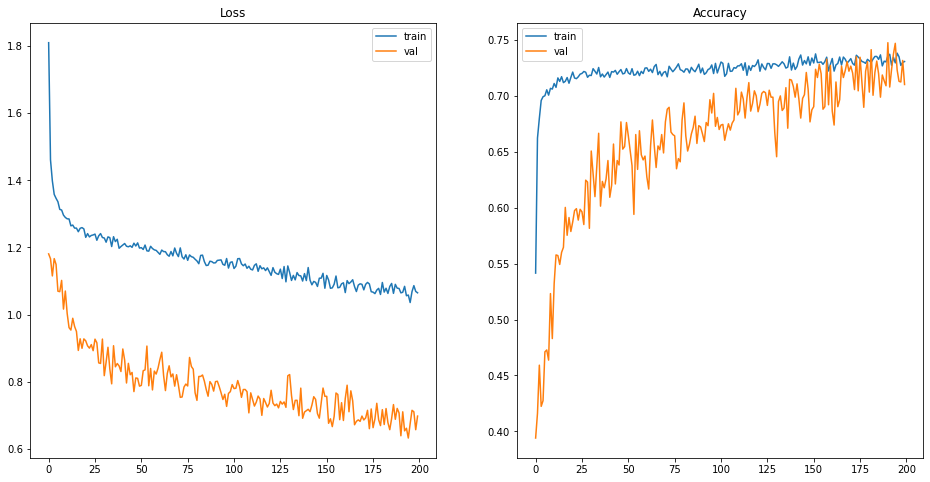

In [45]:
plot_history(window_dnn_history)

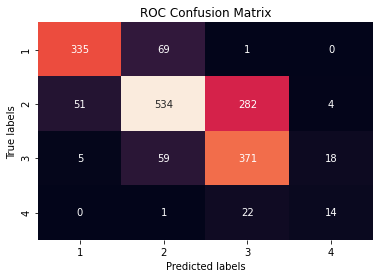

In [81]:
preds = np.argmax(window_dnn.predict(batchX_val), axis=1)
cm = confusion_matrix(batchY_val-1, preds)

xlabel = 'Predicted labels'
ylabel = 'True labels'
title = 'ROC Confusion Matrix'

#use seaborn's sns.heatmap() function for pretty plotting of confusion matrix
ax = sns.heatmap(cm, annot=True, fmt='d', cbar=False)

#set x and y labels, as well as title
ax.set_xticklabels(list(range(1, 5)))
ax.set_xlabel(xlabel)
ax.set_yticklabels(list(range(1, 5)))
ax.set_ylabel(ylabel)
ax.set_title(title)

plt.show()

Again we are close to overfitting, although the accuracy curves look much better for the validation set. And now with regularization?

In [46]:
window_dnn_reg = create_dnn(batchX_train, input_neurons, drop, output_neurons, True)

window_dnn_reg_history = train(window_dnn_reg, batchX_train, batchY_train-1, 
                               batchX_val, batchY_val-1, criterion, optimizer, 
                               batch_size, num_epochs, class_weights)

Epoch 1/200
289/289 [==============================] - 1s 2ms/step - loss: 1.8248 - sparse_categorical_accuracy: 0.5605 - val_loss: 1.2571 - val_sparse_categorical_accuracy: 0.3652
Epoch 2/200
289/289 [==============================] - 0s 2ms/step - loss: 1.4768 - sparse_categorical_accuracy: 0.6579 - val_loss: 1.2563 - val_sparse_categorical_accuracy: 0.3839
Epoch 3/200
289/289 [==============================] - 1s 2ms/step - loss: 1.4111 - sparse_categorical_accuracy: 0.6822 - val_loss: 1.1679 - val_sparse_categorical_accuracy: 0.4207
Epoch 4/200
289/289 [==============================] - 0s 2ms/step - loss: 1.3653 - sparse_categorical_accuracy: 0.6915 - val_loss: 1.1670 - val_sparse_categorical_accuracy: 0.4298
Epoch 5/200
289/289 [==============================] - 0s 2ms/step - loss: 1.3508 - sparse_categorical_accuracy: 0.6933 - val_loss: 1.1126 - val_sparse_categorical_accuracy: 0.4632
Epoch 6/200
289/289 [==============================] - 0s 2ms/step - loss: 1.3220 - sparse_cate

289/289 [==============================] - 1s 3ms/step - loss: 1.2082 - sparse_categorical_accuracy: 0.7293 - val_loss: 0.8631 - val_sparse_categorical_accuracy: 0.6314
Epoch 47/200
289/289 [==============================] - 1s 3ms/step - loss: 1.2089 - sparse_categorical_accuracy: 0.7254 - val_loss: 0.8098 - val_sparse_categorical_accuracy: 0.6614
Epoch 48/200
289/289 [==============================] - 1s 3ms/step - loss: 1.2279 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.8439 - val_sparse_categorical_accuracy: 0.6450
Epoch 49/200
289/289 [==============================] - 1s 3ms/step - loss: 1.2288 - sparse_categorical_accuracy: 0.7242 - val_loss: 0.8512 - val_sparse_categorical_accuracy: 0.6387
Epoch 50/200
289/289 [==============================] - 1s 3ms/step - loss: 1.2166 - sparse_categorical_accuracy: 0.7244 - val_loss: 0.8416 - val_sparse_categorical_accuracy: 0.6455
Epoch 51/200
289/289 [==============================] - 1s 3ms/step - loss: 1.2321 - sparse_categorical

289/289 [==============================] - 1s 3ms/step - loss: 1.1964 - sparse_categorical_accuracy: 0.7257 - val_loss: 0.8083 - val_sparse_categorical_accuracy: 0.6721
Epoch 92/200
289/289 [==============================] - 1s 3ms/step - loss: 1.1794 - sparse_categorical_accuracy: 0.7296 - val_loss: 0.8248 - val_sparse_categorical_accuracy: 0.6580
Epoch 93/200
289/289 [==============================] - 1s 4ms/step - loss: 1.1863 - sparse_categorical_accuracy: 0.7284 - val_loss: 0.8018 - val_sparse_categorical_accuracy: 0.6750
Epoch 94/200
289/289 [==============================] - 1s 4ms/step - loss: 1.1748 - sparse_categorical_accuracy: 0.7250 - val_loss: 0.7673 - val_sparse_categorical_accuracy: 0.6965
Epoch 95/200
289/289 [==============================] - 1s 4ms/step - loss: 1.1981 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7564 - val_sparse_categorical_accuracy: 0.6993
Epoch 96/200
289/289 [==============================] - 1s 5ms/step - loss: 1.1880 - sparse_categorical

Epoch 136/200
289/289 [==============================] - 1s 3ms/step - loss: 1.1738 - sparse_categorical_accuracy: 0.7307 - val_loss: 0.8008 - val_sparse_categorical_accuracy: 0.6801
Epoch 137/200
289/289 [==============================] - 1s 4ms/step - loss: 1.1666 - sparse_categorical_accuracy: 0.7265 - val_loss: 0.8120 - val_sparse_categorical_accuracy: 0.6778
Epoch 138/200
289/289 [==============================] - 1s 3ms/step - loss: 1.1793 - sparse_categorical_accuracy: 0.7256 - val_loss: 0.7298 - val_sparse_categorical_accuracy: 0.7237
Epoch 139/200
289/289 [==============================] - 1s 4ms/step - loss: 1.1781 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.7661 - val_sparse_categorical_accuracy: 0.6982
Epoch 140/200
289/289 [==============================] - 1s 4ms/step - loss: 1.1684 - sparse_categorical_accuracy: 0.7264 - val_loss: 0.7556 - val_sparse_categorical_accuracy: 0.7016
Epoch 141/200
289/289 [==============================] - 1s 3ms/step - loss: 1.1691 -

Epoch 181/200
289/289 [==============================] - 1s 5ms/step - loss: 1.1389 - sparse_categorical_accuracy: 0.7319 - val_loss: 0.7690 - val_sparse_categorical_accuracy: 0.6954
Epoch 182/200
289/289 [==============================] - 1s 5ms/step - loss: 1.1175 - sparse_categorical_accuracy: 0.7361 - val_loss: 0.7568 - val_sparse_categorical_accuracy: 0.7061
Epoch 183/200
289/289 [==============================] - 1s 5ms/step - loss: 1.1631 - sparse_categorical_accuracy: 0.7257 - val_loss: 0.7730 - val_sparse_categorical_accuracy: 0.6931
Epoch 184/200
289/289 [==============================] - 1s 5ms/step - loss: 1.1296 - sparse_categorical_accuracy: 0.7293 - val_loss: 0.7386 - val_sparse_categorical_accuracy: 0.7203
Epoch 185/200
289/289 [==============================] - 1s 5ms/step - loss: 1.1428 - sparse_categorical_accuracy: 0.7283 - val_loss: 0.7505 - val_sparse_categorical_accuracy: 0.7157
Epoch 186/200
289/289 [==============================] - 1s 5ms/step - loss: 1.1352 -

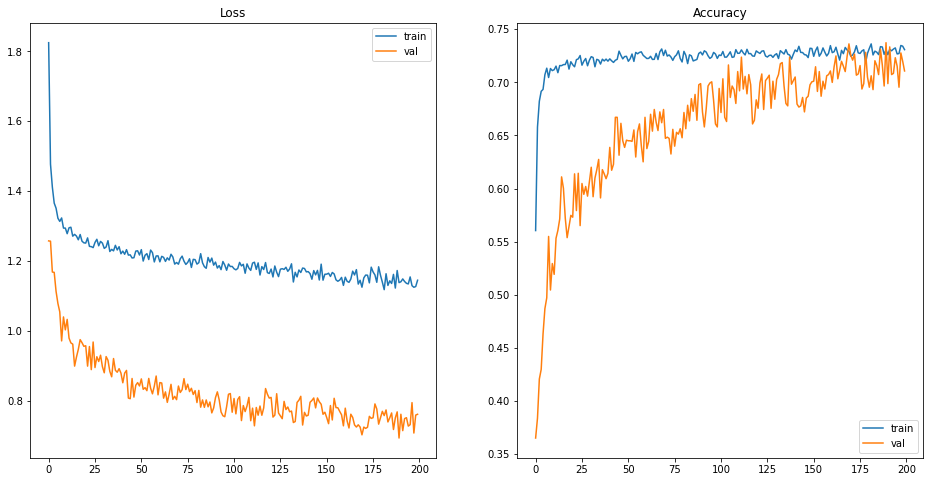

In [47]:
plot_history(window_dnn_reg_history)

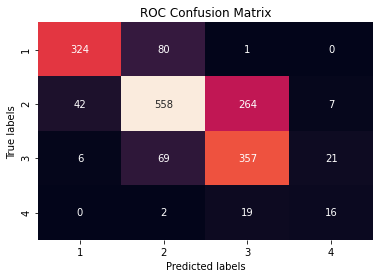

In [80]:
preds = np.argmax(window_dnn_reg.predict(batchX_val), axis=1)
cm = confusion_matrix(batchY_val-1, preds)

xlabel = 'Predicted labels'
ylabel = 'True labels'
title = 'ROC Confusion Matrix'

#use seaborn's sns.heatmap() function for pretty plotting of confusion matrix
ax = sns.heatmap(cm, annot=True, fmt='d', cbar=False)

#set x and y labels, as well as title
ax.set_xticklabels(list(range(1, 5)))
ax.set_xlabel(xlabel)
ax.set_yticklabels(list(range(1, 5)))
ax.set_ylabel(ylabel)
ax.set_title(title)

plt.show()

**DNN Summary**: In general, networks with L2 regularization in the dense layers performed worse. The windowed dataset worked the best for a (terrible) validation set accuracy of ~60%. However, I think the DNN would work better with more layers or a higher learning rate. The loss curves are encouraging for the window-data DNN, though, and I think we should continue playing with hyperparameters for it.

###  LSTM
We can repeat the same steps as above, but this time with a LSTM to see how that affects performance.

In [48]:
def create_rnn(X, n_input, n_dense, dropout, n_output, add_reg=False):
    """
    Create a RNN with or without regularization. Note: X should have
    shape (samples, timesteps, features)
    """
    timesteps = X.shape[1]
    features = X.shape[2]
    
    # design network
    rnn = tf.keras.models.Sequential()
    
    if(add_reg == True):
        reg = tf.keras.regularizers.l2(l=0.0001)
        rnn.add(Bidirectional(LSTM(input_neurons, kernel_regularizer=reg), input_shape=(timesteps, features)))
        rnn.add(Dense(n_dense, kernel_regularizer=reg, activation='elu'))
        
    else:
        rnn.add(Bidirectional(LSTM(input_neurons), input_shape=(timesteps, features)))
        rnn.add(Dense(n_dense, activation='elu'))
    
    rnn.add(Dense(output_neurons, activation='softmax'))
    
    return rnn

In [49]:
input_neurons = 4
dense_neurons = 10

In [50]:
window_rnn = create_rnn(batchX_train, input_neurons, dense_neurons, drop, output_neurons)

window_rnn_history = train(window_rnn, batchX_train, batchY_train-1, 
                           batchX_val, batchY_val-1, criterion, optimizer, 
                           batch_size, num_epochs, class_weights)

Epoch 1/200
289/289 [==============================] - 2s 9ms/step - loss: 1.8017 - sparse_categorical_accuracy: 0.5078 - val_loss: 0.9539 - val_sparse_categorical_accuracy: 0.4700
Epoch 2/200
289/289 [==============================] - 2s 6ms/step - loss: 1.4961 - sparse_categorical_accuracy: 0.6606 - val_loss: 0.9078 - val_sparse_categorical_accuracy: 0.5430
Epoch 3/200
289/289 [==============================] - 2s 5ms/step - loss: 1.4090 - sparse_categorical_accuracy: 0.7018 - val_loss: 0.8835 - val_sparse_categorical_accuracy: 0.5838
Epoch 4/200
289/289 [==============================] - 2s 5ms/step - loss: 1.3672 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.8704 - val_sparse_categorical_accuracy: 0.6048
Epoch 5/200
289/289 [==============================] - 2s 5ms/step - loss: 1.3406 - sparse_categorical_accuracy: 0.7293 - val_loss: 0.8632 - val_sparse_categorical_accuracy: 0.6144
Epoch 6/200
289/289 [==============================] - 2s 5ms/step - loss: 1.3217 - sparse_cate

289/289 [==============================] - 2s 6ms/step - loss: 1.1504 - sparse_categorical_accuracy: 0.7464 - val_loss: 0.7958 - val_sparse_categorical_accuracy: 0.6699
Epoch 47/200
289/289 [==============================] - 2s 6ms/step - loss: 1.1478 - sparse_categorical_accuracy: 0.7460 - val_loss: 0.7936 - val_sparse_categorical_accuracy: 0.6721
Epoch 48/200
289/289 [==============================] - 2s 5ms/step - loss: 1.1451 - sparse_categorical_accuracy: 0.7466 - val_loss: 0.7916 - val_sparse_categorical_accuracy: 0.6733
Epoch 49/200
289/289 [==============================] - 2s 5ms/step - loss: 1.1425 - sparse_categorical_accuracy: 0.7472 - val_loss: 0.7899 - val_sparse_categorical_accuracy: 0.6744
Epoch 50/200
289/289 [==============================] - 2s 6ms/step - loss: 1.1399 - sparse_categorical_accuracy: 0.7474 - val_loss: 0.7888 - val_sparse_categorical_accuracy: 0.6755
Epoch 51/200
289/289 [==============================] - 2s 6ms/step - loss: 1.1373 - sparse_categorical

289/289 [==============================] - 2s 6ms/step - loss: 1.0562 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.7510 - val_sparse_categorical_accuracy: 0.6897
Epoch 92/200
289/289 [==============================] - 2s 6ms/step - loss: 1.0553 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.7611 - val_sparse_categorical_accuracy: 0.6835
Epoch 93/200
289/289 [==============================] - 2s 6ms/step - loss: 1.0526 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.7452 - val_sparse_categorical_accuracy: 0.6931
Epoch 94/200
289/289 [==============================] - 2s 5ms/step - loss: 1.0519 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.7593 - val_sparse_categorical_accuracy: 0.6835
Epoch 95/200
289/289 [==============================] - 2s 5ms/step - loss: 1.0493 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.7374 - val_sparse_categorical_accuracy: 0.6965
Epoch 96/200
289/289 [==============================] - 2s 5ms/step - loss: 1.0484 - sparse_categorical

Epoch 136/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9791 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.7127 - val_sparse_categorical_accuracy: 0.7152
Epoch 137/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9767 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.7123 - val_sparse_categorical_accuracy: 0.7135
Epoch 138/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9762 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.7113 - val_sparse_categorical_accuracy: 0.7169
Epoch 139/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9739 - sparse_categorical_accuracy: 0.7550 - val_loss: 0.6948 - val_sparse_categorical_accuracy: 0.7271
Epoch 140/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9746 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.7064 - val_sparse_categorical_accuracy: 0.7191
Epoch 141/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9727 -

Epoch 181/200
289/289 [==============================] - 1s 5ms/step - loss: 0.9213 - sparse_categorical_accuracy: 0.7601 - val_loss: 0.7036 - val_sparse_categorical_accuracy: 0.7180
Epoch 182/200
289/289 [==============================] - 1s 5ms/step - loss: 0.9158 - sparse_categorical_accuracy: 0.7605 - val_loss: 0.7073 - val_sparse_categorical_accuracy: 0.7203
Epoch 183/200
289/289 [==============================] - 2s 5ms/step - loss: 0.9142 - sparse_categorical_accuracy: 0.7611 - val_loss: 0.7084 - val_sparse_categorical_accuracy: 0.7191
Epoch 184/200
289/289 [==============================] - 2s 5ms/step - loss: 0.9130 - sparse_categorical_accuracy: 0.7617 - val_loss: 0.7086 - val_sparse_categorical_accuracy: 0.7197
Epoch 185/200
289/289 [==============================] - 2s 5ms/step - loss: 0.9114 - sparse_categorical_accuracy: 0.7619 - val_loss: 0.7082 - val_sparse_categorical_accuracy: 0.7203
Epoch 186/200
289/289 [==============================] - 2s 5ms/step - loss: 0.9147 -

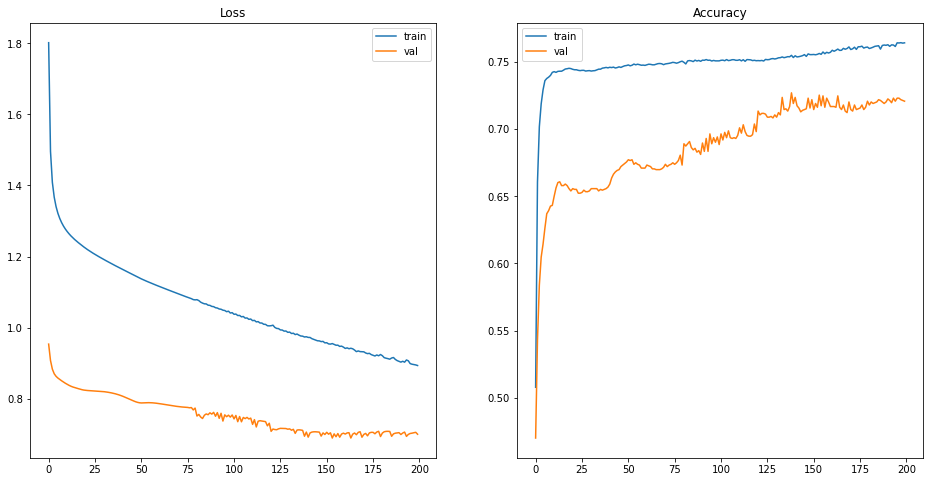

In [51]:
plot_history(window_rnn_history)

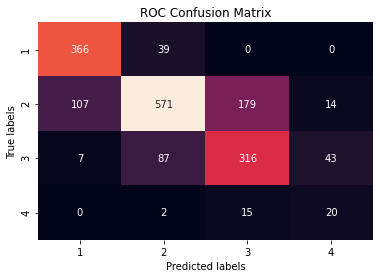

In [78]:
preds = np.argmax(window_rnn.predict(batchX_val), axis=1)
cm = confusion_matrix(batchY_val-1, preds)

xlabel = 'Predicted labels'
ylabel = 'True labels'
title = 'ROC Confusion Matrix'

#use seaborn's sns.heatmap() function for pretty plotting of confusion matrix
ax = sns.heatmap(cm, annot=True, fmt='d', cbar=False)

#set x and y labels, as well as title
ax.set_xticklabels(list(range(1, 5)))
ax.set_xlabel(xlabel)
ax.set_yticklabels(list(range(1, 5)))
ax.set_ylabel(ylabel)
ax.set_title(title)

plt.show()

This looks like a classic case of [overfitting](https://en.wikipedia.org/wiki/Overfitting). Our validation loss starts increasing and our training loss continues decreasing. We could try to fix this with trying to add regularization to our network, or using a different architecture (maybe with less layers or neurons per layer).

In [52]:
window_rnn_reg = create_rnn(batchX_train, input_neurons, dense_neurons, drop, output_neurons, True)

window_rnn_reg_history = train(window_rnn_reg, batchX_train, batchY_train-1, 
                               batchX_val, batchY_val-1, criterion, optimizer, 
                               batch_size, num_epochs, class_weights)

Epoch 1/200
289/289 [==============================] - 3s 9ms/step - loss: 1.8296 - sparse_categorical_accuracy: 0.5131 - val_loss: 0.9684 - val_sparse_categorical_accuracy: 0.4955
Epoch 2/200
289/289 [==============================] - 2s 6ms/step - loss: 1.4833 - sparse_categorical_accuracy: 0.6520 - val_loss: 0.8655 - val_sparse_categorical_accuracy: 0.6031
Epoch 3/200
289/289 [==============================] - 2s 6ms/step - loss: 1.3932 - sparse_categorical_accuracy: 0.6876 - val_loss: 0.8387 - val_sparse_categorical_accuracy: 0.6387
Epoch 4/200
289/289 [==============================] - 2s 6ms/step - loss: 1.3512 - sparse_categorical_accuracy: 0.7017 - val_loss: 0.8368 - val_sparse_categorical_accuracy: 0.6376
Epoch 5/200
289/289 [==============================] - 2s 6ms/step - loss: 1.3266 - sparse_categorical_accuracy: 0.7122 - val_loss: 0.8328 - val_sparse_categorical_accuracy: 0.6455
Epoch 6/200
289/289 [==============================] - 2s 6ms/step - loss: 1.3099 - sparse_cate

289/289 [==============================] - 2s 5ms/step - loss: 1.1462 - sparse_categorical_accuracy: 0.7410 - val_loss: 0.7809 - val_sparse_categorical_accuracy: 0.6823
Epoch 47/200
289/289 [==============================] - 2s 5ms/step - loss: 1.1435 - sparse_categorical_accuracy: 0.7410 - val_loss: 0.7795 - val_sparse_categorical_accuracy: 0.6846
Epoch 48/200
289/289 [==============================] - 2s 5ms/step - loss: 1.1408 - sparse_categorical_accuracy: 0.7413 - val_loss: 0.7781 - val_sparse_categorical_accuracy: 0.6857
Epoch 49/200
289/289 [==============================] - 2s 7ms/step - loss: 1.1382 - sparse_categorical_accuracy: 0.7415 - val_loss: 0.7766 - val_sparse_categorical_accuracy: 0.6863
Epoch 50/200
289/289 [==============================] - 2s 8ms/step - loss: 1.1356 - sparse_categorical_accuracy: 0.7407 - val_loss: 0.7750 - val_sparse_categorical_accuracy: 0.6874
Epoch 51/200
289/289 [==============================] - 2s 8ms/step - loss: 1.1330 - sparse_categorical

289/289 [==============================] - 2s 6ms/step - loss: 1.0498 - sparse_categorical_accuracy: 0.7475 - val_loss: 0.7209 - val_sparse_categorical_accuracy: 0.7163
Epoch 92/200
289/289 [==============================] - 2s 6ms/step - loss: 1.0481 - sparse_categorical_accuracy: 0.7478 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.7169
Epoch 93/200
289/289 [==============================] - 2s 6ms/step - loss: 1.0463 - sparse_categorical_accuracy: 0.7476 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.7146
Epoch 94/200
289/289 [==============================] - 2s 6ms/step - loss: 1.0445 - sparse_categorical_accuracy: 0.7485 - val_loss: 0.7204 - val_sparse_categorical_accuracy: 0.7140
Epoch 95/200
289/289 [==============================] - 2s 6ms/step - loss: 1.0428 - sparse_categorical_accuracy: 0.7483 - val_loss: 0.7203 - val_sparse_categorical_accuracy: 0.7169
Epoch 96/200
289/289 [==============================] - 2s 6ms/step - loss: 1.0411 - sparse_categorical

Epoch 136/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9823 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.7418 - val_sparse_categorical_accuracy: 0.7140
Epoch 137/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9811 - sparse_categorical_accuracy: 0.7550 - val_loss: 0.7412 - val_sparse_categorical_accuracy: 0.7123
Epoch 138/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9803 - sparse_categorical_accuracy: 0.7560 - val_loss: 0.7440 - val_sparse_categorical_accuracy: 0.7112
Epoch 139/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9791 - sparse_categorical_accuracy: 0.7555 - val_loss: 0.7445 - val_sparse_categorical_accuracy: 0.7112
Epoch 140/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9778 - sparse_categorical_accuracy: 0.7560 - val_loss: 0.7449 - val_sparse_categorical_accuracy: 0.7106
Epoch 141/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9770 -

Epoch 181/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9327 - sparse_categorical_accuracy: 0.7609 - val_loss: 0.7479 - val_sparse_categorical_accuracy: 0.7146
Epoch 182/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9327 - sparse_categorical_accuracy: 0.7617 - val_loss: 0.7487 - val_sparse_categorical_accuracy: 0.7152
Epoch 183/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9318 - sparse_categorical_accuracy: 0.7608 - val_loss: 0.7453 - val_sparse_categorical_accuracy: 0.7163
Epoch 184/200
289/289 [==============================] - 2s 7ms/step - loss: 0.9302 - sparse_categorical_accuracy: 0.7619 - val_loss: 0.7486 - val_sparse_categorical_accuracy: 0.7169
Epoch 185/200
289/289 [==============================] - 2s 7ms/step - loss: 0.9299 - sparse_categorical_accuracy: 0.7625 - val_loss: 0.7483 - val_sparse_categorical_accuracy: 0.7169
Epoch 186/200
289/289 [==============================] - 2s 6ms/step - loss: 0.9279 -

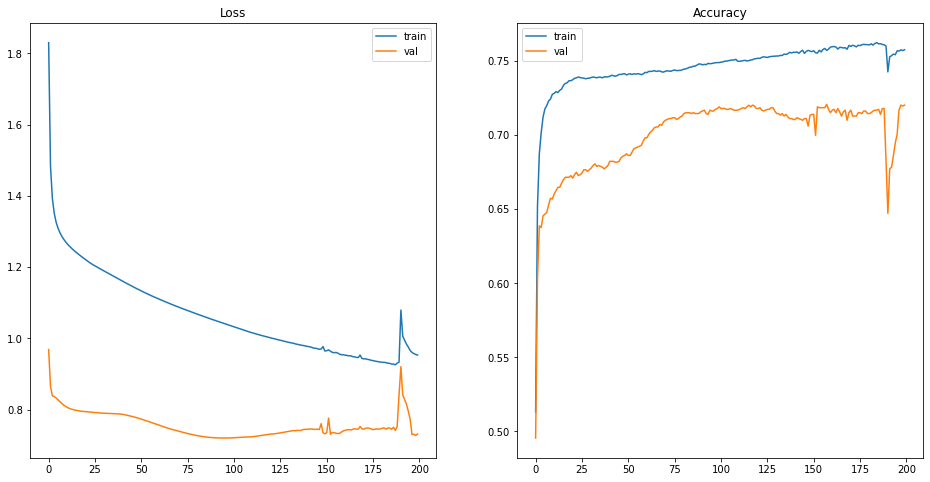

In [53]:
plot_history(window_rnn_reg_history)

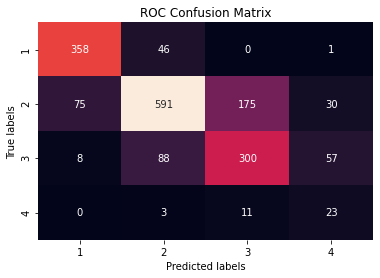

In [79]:
preds = np.argmax(window_rnn_reg.predict(batchX_val), axis=1)
cm = confusion_matrix(batchY_val-1, preds)

xlabel = 'Predicted labels'
ylabel = 'True labels'
title = 'ROC Confusion Matrix'

#use seaborn's sns.heatmap() function for pretty plotting of confusion matrix
ax = sns.heatmap(cm, annot=True, fmt='d', cbar=False)

#set x and y labels, as well as title
ax.set_xticklabels(list(range(1, 5)))
ax.set_xlabel(xlabel)
ax.set_yticklabels(list(range(1, 5)))
ax.set_ylabel(ylabel)
ax.set_title(title)

plt.show()

**RNN Summary**: In the RNN case, we get a boost in performance if we use a window dataset with L2 regularization.